## Burgers: One-pfive step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
# Import values from 2-step
two_step_dict = np.load('data/two_step_dict.npy', allow_pickle=True)
two_step_dict = two_step_dict.item()

In [5]:
two_step_dict

{'optim_sgm_u': array([2.96574483]),
 'optim_nugget_u': array([2.97635144e-11]),
 'rkhs_u': [95713.68448437436],
 'optim_sgm_P': 0.5714432601422236,
 'optim_nugget_P': 7.847599703514623e-13,
 'nugget_P': 1e-07,
 'rkhs_P': 180.91761304813213,
 'f_pred_test': array([-2.06753612e-07, -1.19581819e-06, -2.00274758e-01, ...,
        -1.19007174e-02, -1.83284283e-06,  1.91243365e-03])}

### Cost function

Create objective function `L`

$$
L(Z_0) = f(X_N)^T \Gamma(S_N,S_N)^{-1} f(X_N) + \lambda \sum_{i=1}^m (Z_{0,i*N:(i+1)*N})^T K(X_N,X_N)^{-1}(Z_{0,i*N:(i+1)*N})
$$
where
$$
Z_0[M] = U[M].
$$

1. Test by M = [True].

In [75]:
def L(Z, X, U, M, f, two_step_dict, lmbd):
    """Cost function for 1.5-step method.
    
    Args:
        Z: Vector [Z^1 Z^2 Z^3]^T. m*N
        X: List of mN points of dimension d.
        U: List of N1+N2+N3 values of functions u^(1),...u^(N).
        M: Bolean array which contains where true values reside.
        f: List of mN values of functions u^(1),...u^(N).
        two_step_dict: Dictionary with values from 2-step.
        lmbd: Lagrange multiplier in the loss function.
    Returns:
        scalar: a cost of this solution.    
    """ 

    ### Set up
    N = 10 
    m = 3 
    #print('Z:', Z)
    # Constrain the value of Z with known info
    #Z = jnp.where(M, U, Z)
    # Just use Z_warm instead of using line 21.
    # Cd + 1 = 4
    S = jnp.zeros((N*m,4))
    
    # Split Z
    for i in range(m):
        Zi = Z[i*N:(i+1)*N]
        optim_sgm = two_step_dict.get('optim_sgm_u')[i]
        optim_nugget = two_step_dict.get('optim_nugget_u')[i]
        G = K(Gaussian, X[:N], X[:N], optim_sgm) 
        alphas = jnp.linalg.solve(G + optim_nugget*jnp.eye(N),Zi)

        Zi_x = jnp.dot(K_dot(Gaussian, X[:N], X[:N], optim_sgm, 0), alphas)
        Zi_xx = jnp.dot(K_2dot(Gaussian, X[:N], X[:N], optim_sgm, 0,0), alphas)

        Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
        # print shapes and values here
        S = S.at[i*N:(i+1)*N,:].set(Si)
    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    # Gamma(S_N,S_N)
    optim_sgm_P = two_step_dict.get('optim_sgm_P') 
    Gamma = K(Gaussian, S, S, optim_sgm_P)
    nugget_P = two_step_dict.get('nugget_P') 
    Gamma = Gamma + nugget_P*jnp.eye(jnp.size(Gamma,0))
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    L1 = jnp.dot(f.T , b) / two_step_dict.get('rkhs_P')
    #print('L1: ', L1)

    # Second term
    sigma_K = jnp.array(two_step_dict.get('optim_sgm_u'))
    nugget_K = two_step_dict.get('optim_nugget_u')
    K_XNs = []
    for i in range(m):
        K_XN = K(Gaussian,X[:N],X[:N],sigma_K[i]) 
        K_XNs.append(K_XN + nugget_K[i]*jnp.eye(N))
    
    L2 = 0.
    
    for i in range(m):
        #print('Z_constrained:', Z_warm)
        Zi = Z[i*N:(i+1)*N] # print out each of these and display the graphs here ! 
        c = jnp.linalg.solve(K_XNs[i],Zi)
        #print(K_XNs[i][:5,:5])
        #print(Zi)
        #print(Zi.shape)
        #print(c)
        L2 += jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i]
        #print('L2_',i,':',jnp.reshape(jnp.dot(Zi.T , c),()) / two_step_dict.get('rkhs_u')[i] )      
    
    return L1 + lmbd*L2
    

#### Gradient descent

Training data

In [76]:
# First column in Gamma(S_N,S_N)
X = x_test_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_test.T.reshape(N*m,) # N*m * 1

# f(X_N)
#f = f_Test(model,e_test)
f = two_step_dict['f_pred_test']

Initial guess: `Z_warm`

In [77]:
# Load values of U predicted from 2-step
u_pred_test = np.load('data/u_pred_test.npy')
u_x_pred_test = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
# Build Z_warm
Z_warm = jnp.array(u_pred_test.T.reshape(N*m,)) 

In [78]:
lmbda = 1e5

In [79]:
L(Z_warm, X, U, M, f, two_step_dict, lmbd=lmbda)

Array(300001.58624811, dtype=float64)

Initialize the grad functions with `jit` to be efficient

In [80]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, M, f, two_step_dict, lmbda)
# Warm start here !!!

Array([ 3.08269173e+01, -8.27407638e+01,  8.42692156e+01, -3.02349214e+01,
        7.40307777e+04,  7.98210492e+00, -7.15267765e+00, -2.08974800e+05,
        4.84229404e+04, -7.11664363e-01,  3.32363765e+03, -1.38479469e+04,
        2.22024009e+05,  1.68280203e+05, -1.40899942e+05, -3.84025618e+05,
       -2.84089889e+05,  1.33000114e+05,  4.41880863e+05, -8.24337285e+04,
       -1.90193044e+02,  7.80442763e+04, -5.95353389e+03, -1.05703249e+05,
       -1.81882511e+04,  1.68573062e+04, -1.03173923e+04,  6.38334585e+04,
       -8.88829057e+02,  8.54308758e+01], dtype=float64)

Run the gradient descent for `100` epochs

### Optimization of L

In [81]:
# Load the warm-up
Z = np.copy(Z_warm)

In [82]:
# u_t = u_train.T.reshape(N*m,1)
# # Load true gradients from 2-step
# u_x_train = np.load('data/u_x_train.npy')
# u_xx_train = np.load('data/u_xx_train.npy')
# # Build true Z
# Z_true = np.hstack([u_t, u_x_train.T.reshape(N*m,1),u_xx_train.T.reshape(N*m,1)])

In [83]:
# Only do this for the first time - 
#Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

0. Run it for more iterations until it actually converges to a minimum!!!
1. Line search (using $p_k = - \nabla f$) using Armijo condition. Pick $\alpha_k$ such that satisfy the two Wolfe conditions. Test: Loss must always goes down here. 
2. Newton-Armijo.
3. Read Quasi-Newton algorithm in Nocedal, when the Hessian is not PD.  

In [84]:
# mses = []
# S = jnp.zeros((N*m,4))
# kernel = Gaussian
# If trained previously use Z
# if np.all(Z != Z_warm):
#     Z = np.load('data/Z.npy')
# else:
#     Z = np.copy(Z_warm)
Z = np.copy(Z_warm)
learning_rate = 1e-12
for i in range(1000):
    delta_Z = grad_Z(Z, X, U, M, f, two_step_dict, lmbda)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    
    # # Pred
    # for j in range(m):
    #     Zi = Z[j*N:(j+1)*N]
    #     #optim_sgm , optim_lmbd = grid_search_RBF_JAX(X[:N].reshape(N,1),Zi.reshape(-1,1))
    #     optim_sgm , optim_lmbd = 0.5, 1e-4
    #     G = K(kernel, X[:N], X[:N], optim_sgm) 
    #     alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    #     Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    #     Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    #     Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    #     S = S.at[j*N:(j+1)*N,:].set(Si)
    # Spred = S[:,-3:]
    # mse = mean_squared_error(Spred,Z_true)/mean_squared_error(0*Spred,Z_true)
    # mses.append(mse)
    if i % 10 == 0:
        print('iter:', i )
        print('loss: ',L(Z, X, U, M, f, two_step_dict, lmbda))
        #print('mse:', mse)
    
# Save at the end of iterations
#np.save('data/Z.npy',Z)

iter: 0
loss:  300001.586230009
iter: 10
loss:  300001.5861044218
iter: 20
loss:  300001.58601710474
iter: 30
loss:  300001.5859298642
iter: 40
loss:  300001.58584262646
iter: 50
loss:  300001.58575538814
iter: 60
loss:  300001.58566815325
iter: 70
loss:  300001.58558091905
iter: 80
loss:  300001.5854936848
iter: 90
loss:  300001.5854064526
iter: 100
loss:  300001.585319224
iter: 110
loss:  300001.5852319949
iter: 120
loss:  300001.58514476765
iter: 130
loss:  300001.5850575412
iter: 140
loss:  300001.5849703163
iter: 150
loss:  300001.5848830929
iter: 160
loss:  300001.58479586995
iter: 170
loss:  300001.5847086474
iter: 180
loss:  300001.584621428
iter: 190
loss:  300001.5845342102
iter: 200
loss:  300001.5844469918
iter: 210
loss:  300001.5843597767
iter: 220
loss:  300001.58427256084
iter: 230
loss:  300001.5841853477
iter: 240
loss:  300001.5840981368
iter: 250
loss:  300001.5840109255
iter: 260
loss:  300001.5839237163
iter: 270
loss:  300001.5838365078
iter: 280
loss:  300001.58

- If it does decrease the loss for 10 steps then look for a different alpha, say alpha bigger than it was to make the algorithm more efficient ( if we find for example a flat region).

In [86]:
np.all(Z_warm==Z)

Array(False, dtype=bool)

Evaluate `Z`

In [87]:
# Build S_N - Training data
S = jnp.zeros((N*m,4))
kernel = Gaussian
# Split Z
for i in tqdm(range(m)):
    Zi = Z[i*N:(i+1)*N]
    optim_sgm , optim_lmbd = two_step_dict.get('optim_sgm_u')[i], two_step_dict.get('optim_nugget_u')[i]
    G = K(kernel, X[:N], X[:N], optim_sgm) 
    alphas = jnp.linalg.solve(G + optim_lmbd*jnp.eye(N),Zi)
    Zi_x = jnp.dot(K_dot(kernel, X[:N], X[:N], optim_sgm, 0), alphas)
    Zi_xx = jnp.dot(K_2dot(kernel, X[:N], X[:N], optim_sgm, 0,0), alphas)
    Si = jnp.vstack((X[:N],Zi, Zi_x,Zi_xx)).T
    S = S.at[i*N:(i+1)*N,:].set(Si)

# Load gradients from 2-step
u_x_pred_test  = np.load('data/u_x_pred_test.npy')
u_xx_pred_test = np.load('data/u_xx_pred_test.npy')
s_test = np.hstack((x_test_all.reshape(-1,1),u_test.T.reshape(-1,1),u_x_pred_test.T.reshape(-1,1),u_xx_pred_test.T.reshape(-1,1)))  # 30 * 4
f_train = f_Train(model)
f_test = f_Test(model,e_test)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(S)
s_test_s = scaler_s_train.transform(s_test)

optim_sgm_P, optim_nugget_P = grid_search_RBF(s_train_s,f_test)

krr_optimal_P = KernelRidge(kernel='rbf', alpha = two_step_dict.get('optim_nugget_P'), gamma=1/(2*(two_step_dict.get('optim_sgm_P')**2))) 
krr_optimal_P.fit(s_train_s, f_test) 
f_pred_train = krr_optimal_P.predict(s_train_s) 
f_pred_test = krr_optimal_P.predict(s_test_s)

100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


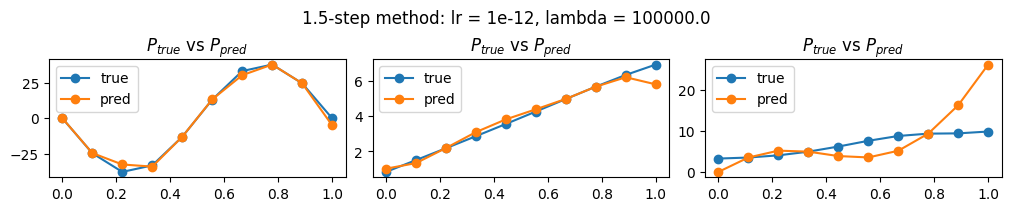

In [89]:
# Plot at testing points
fig, axs = plt.subplots(nrows = 1, ncols=3 , figsize = (10, 2),constrained_layout=True)
fig.suptitle(f'1.5-step method: lr = {learning_rate}, lambda = {lmbda}')
axs[0].plot(x_test[:e_test], f_test[:e_test] , marker= 'o', label = 'true')
axs[0].plot(x_test[:e_test], f_pred_test[:e_test], marker= 'o', label = 'pred')
axs[0].legend()
axs[0].set_title('$P_{true}$ vs $P_{pred}$')
axs[1].plot(x_test[e_test:2*e_test], f_test[e_test:2*e_test],marker= 'o', label = 'true')
axs[1].plot(x_test[e_test:2*e_test], f_pred_test[e_test:2*e_test],marker= 'o', label = 'pred')
axs[1].legend()
axs[1].set_title('$P_{true}$ vs $P_{pred}$')
axs[2].plot(x_test[2*e_test:3*e_test], f_test[2*e_test:3*e_test],marker= 'o', label = 'true')
axs[2].plot(x_test[2*e_test:3*e_test], f_pred_test[2*e_test:3*e_test],marker= 'o', label = 'pred')
axs[2].legend()
axs[2].set_title('$P_{true}$ vs $P_{pred}$')
fig.show()